## Machine Learning Pipeline - Feature Engineering with Open-Source
In the following notebooks, we will go through the implementation of each steps in the Machine Learning Pipeline: 

1. Data Analysis
2. **Feature Engineering**
3. Feature Selection
4. Model Training
5. Obtaining Predictions/Scoring

### Rossman Store Sales Prediction
The aim of the project is to build an end-to-end machine learning model to predict the sales of a given store and a set of inputs, including the promotions, competition, school and state holidays, seasonality, and locality.

In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.impute import SimpleImputer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [3]:
# load dataset
df_sales = pd.read_csv('train.csv')
df_store = pd.read_csv('store.csv')

# rows and columns of the data
print(df_sales.shape)
print(df_store.shape)

(914629, 9)
(1115, 10)


C:\Users\benja\anaconda3\envs\test-ml-gcash-rossmann-research\lib\site-packages\IPython\core\interactiveshell.py:3012: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Merge
df_raw = pd.merge( df_sales, df_store, how = 'left', on = 'Store' )

print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914629 entries, 0 to 914628
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      914629 non-null  int64  
 1   DayOfWeek                  914629 non-null  int64  
 2   Date                       914629 non-null  object 
 3   Sales                      914629 non-null  int64  
 4   Customers                  914629 non-null  int64  
 5   Open                       914629 non-null  int64  
 6   Promo                      914629 non-null  int64  
 7   StateHoliday               914629 non-null  object 
 8   SchoolHoliday              914629 non-null  int64  
 9   StoreType                  914629 non-null  object 
 10  Assortment                 914629 non-null  object 
 11  CompetitionDistance        912263 non-null  float64
 12  CompetitionOpenSinceMonth  623849 non-null  float64
 13  CompetitionOpenSinceYear   62

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-04-30,6228,650,1,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4,2015-04-30,6884,716,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,4,2015-04-30,9971,979,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,2015-04-30,16106,1854,1,1,0,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4,2015-04-30,6598,729,1,1,0,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# copy dataset
df1 = df_raw.copy()

# drop all rows with zero Sales amount
df1 = df1[df1['Sales'] > 0]

print(df1.shape)
df1.head()

(759848, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-04-30,6228,650,1,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4,2015-04-30,6884,716,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,4,2015-04-30,9971,979,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,2015-04-30,16106,1854,1,1,0,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4,2015-04-30,6598,729,1,1,0,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Separate dataset into train and test
When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

* mean
* mode
* exponents from the yeo-johnson
* category frequency
* and category to number mappings

from the train set.

In [6]:
# separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(['Store', 'Sales'], axis=1), # predictive variables
    df1['Sales'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((607878, 16), (151970, 16))

### Feature Engineering
In the following cells, we will engineer the variables:
1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: convert strings to numbers
5. Put the variables in a similar scale

In [7]:
# for target, we apply the logarithm (log1p)
y_train = np.log1p(y_train) # = np.log(y_train + 1)
y_test = np.log1p(y_test)

### Missing Values
#### Categorical variables
We will replace missing values with the string "missing" in those variables with at least 50% of missing data. <br>
Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values.

In [8]:
#  transform datatype of the variable date to datetime
X_train['Date'] = pd.to_datetime(X_train['Date'])
X_test['Date'] = pd.to_datetime(X_test['Date'])

In [9]:
# identify the categorical variables; capture all those with type "object"
cat_vars = [var for var in df1.columns if df1[var].dtype == 'O' and var != 'Date']
cat_vars

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [10]:
# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

In [11]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

PromoInterval    0.502254
dtype: float64

In [12]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() >= 0.50]

with_string_missing   

['PromoInterval']

In [13]:
# replace missing values with new label: "Missing"

# set up the class
cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing)

# fit the class to the train set
cat_imputer_missing.fit(X_train)    

# the class learns and stores the parameters
cat_imputer_missing.imputer_dict_

{'PromoInterval': 'Missing'}

In [14]:
# replace NA by missing

# IMPORTANT: note that we could store this class with joblib
X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

In [15]:
# check that we have no missing information in the engineered variables

X_train[cat_vars_with_na].isnull().sum()

PromoInterval    0
dtype: int64

In [16]:
# check that test set does not contain null values in the engineered variables

[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

#### Numerical variables
To engineer missing values in numerical variables, we will:
* add a binary missing indicator variable
* and then replace the missing values in the original variable with the mean or mode

In [17]:
# identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'Sales'
]

num_vars

['DayOfWeek',
 'Date',
 'Customers',
 'Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear']

In [18]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean().sort_values(ascending=False)

Promo2SinceWeek              0.502254
Promo2SinceYear              0.502254
CompetitionOpenSinceMonth    0.317962
CompetitionOpenSinceYear     0.317962
CompetitionDistance          0.002596
dtype: float64

In [19]:
# add missing indicator
missing_ind = AddMissingIndicator(variables=vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)


In [22]:
# check the binary missing indicator variables
X_train[['Promo2SinceWeek_na', 'Promo2SinceYear_na', 'CompetitionOpenSinceMonth_na',
        'CompetitionOpenSinceYear_na', 'CompetitionDistance_na']].head()

,Promo2SinceWeek_na,Promo2SinceYear_na,CompetitionOpenSinceMonth_na,CompetitionOpenSinceYear_na,CompetitionDistance_na
909242,0,0,1,1,0
865171,0,0,1,1,0
826279,0,0,0,0,0
524907,0,0,1,1,0
589075,1,1,1,1,0


In [23]:
# then replace the missing data with the mean

# set the imputer
mean_imputer = MeanMedianImputer(
    imputation_method='mean', variables=['CompetitionDistance'])

# learn and store parameters from train set
mean_imputer.fit(X_train)

# the stored parameters
mean_imputer.imputer_dict_

{'CompetitionDistance': 5461.426917367639}

In [25]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

In [26]:
# check that we have no more missing values in the engineered variables
X_train['CompetitionDistance'].isnull().sum()

0

In [29]:
# check that test set does not contain null values in the engineered variables
[var for var in ['CompetitionDistance'] if X_test[var].isnull().sum() > 0]

[]

In [36]:
# replace the rest of the missing variables with the mode

impute_lst = [var for var in vars_with_na if var != 'CompetitionDistance']

# set the imputer
mode_imputer = SimpleImputer(missing_values=np.nan, 
                            strategy='most_frequent')

# learn the parameters from the train set
mode_imputer = mode_imputer.fit(X_train[impute_lst])

X_train[impute_lst] = mode_imputer.transform(X_train[impute_lst])
X_test[impute_lst] = mode_imputer.transform(X_test[impute_lst])


In [37]:
# check that we have no more missing values in the engineered variables
X_train[impute_lst].isnull().sum()

CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2SinceWeek              0
Promo2SinceYear              0
dtype: int64

In [38]:
# check that test set does not contain null values in the engineered variables
[var for var in impute_lst if X_test[var].isnull().sum() > 0]

[]

### Temporal variables

In [40]:
# year
X_train['year'] = X_train['Date'].dt.year
X_test['year'] = X_test['Date'].dt.year

X_train.head()

,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionDistance_na,CompetitionOpenSinceMonth_na,CompetitionOpenSinceYear_na,Promo2SinceWeek_na,Promo2SinceYear_na,year
909242,6,2013-01-05,442,1,0,0,0,d,a,850.0,9.0,2013.0,1,18.0,2011.0,"Feb,May,Aug,Nov",0,1,1,0,0,2013
865171,4,2013-02-14,479,1,0,0,0,d,c,310.0,9.0,2013.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",0,1,1,0,0,2013
826279,4,2013-03-21,693,1,1,0,0,d,a,1120.0,5.0,2007.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0,0,0,0,0,2013
524907,1,2013-12-16,1617,1,1,0,0,a,c,20620.0,9.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",0,1,1,0,0,2013
589075,6,2013-10-19,438,1,0,0,0,d,a,2300.0,9.0,2013.0,0,14.0,2011.0,Missing,0,1,1,1,1,2013


In [41]:
def elapsed_years(df, var):
    """
    Capture difference between the year variable
    and other date-related (year) variables
    """
    df[var] = abs(df['year'] - df[var])
    return df

In [43]:
# capture difference between the year variable
# and the year in the nearest competitor was opened
# and when the store started participating in Promo2
for var in ['CompetitionOpenSinceYear', 'Promo2SinceYear']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [44]:
# drop columns
drop_features = DropFeatures(features_to_drop=['Date','Promo2SinceWeek',
                                               'year', 'Promo2SinceWeek_na'])

X_train = drop_features.fit_transform(X_train)
X_test = drop_features.transform(X_test)

In [45]:
X_train.head()

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionDistance_na,CompetitionOpenSinceMonth_na,CompetitionOpenSinceYear_na,Promo2SinceYear_na
909242,6,442,1,0,0,0,d,a,850.0,9.0,0.0,1,2.0,"Feb,May,Aug,Nov",0,1,1,0
865171,4,479,1,0,0,0,d,c,310.0,9.0,0.0,1,2.0,"Jan,Apr,Jul,Oct",0,1,1,0
826279,4,693,1,1,0,0,d,a,1120.0,5.0,6.0,1,0.0,"Jan,Apr,Jul,Oct",0,0,0,0
524907,1,1617,1,1,0,0,a,c,20620.0,9.0,0.0,1,4.0,"Jan,Apr,Jul,Oct",0,1,1,0
589075,6,438,1,0,0,0,d,a,2300.0,9.0,0.0,0,2.0,Missing,0,1,1,1


### Numerical variable transformation
#### Yeo-Johnson transformation
We will apply the Yeo-Johnson transformation to CompetitionDistance


In [46]:
yeo_transformer = YeoJohnsonTransformer(
    variables=['CompetitionDistance'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

{'CompetitionDistance': 0.09805857795188087}

In [47]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [48]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

#### Logarithmic transformation
We will apply the Logarithmic transformation to Customers

In [49]:
log_transformer = LogTransformer(
    variables=["Customers"])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

In [50]:
# check that test set does not contain null values in the engineered variables
[var for var in ["Customers"] if X_test[var].isnull().sum() > 0]

[]

In [51]:
# same for the train set
[var for var in ["Customers"] if X_train[var].isnull().sum() > 0]

[]

### Categorical variables
#### Apply mappings
The variable **Assortment** have values in assigned order

In [52]:
# re-map strings to numbers, which determines the assortment level
assortment_mappings = {'a':1, 'b':2, 'c': 3}

for var in ["Assortment"]:
    X_train[var] = X_train[var].map(assortment_mappings)
    X_test[var] = X_test[var].map(assortment_mappings)

#### Removing rare labels
For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. <br>
That is, all values of categorical variables that are shared by less than 1% of stores will be replaced by the string "Rare".

In [53]:
# capture the remaining categorical variables
cat_others = [var for var in cat_vars if var != "Assortment"]

cat_others

['StateHoliday', 'StoreType', 'PromoInterval']

In [54]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later :)
rare_encoder.encoder_dict_

{'StateHoliday': Index(['0', 0], dtype='object'),
 'StoreType': Index(['a', 'd', 'c', 'b'], dtype='object'),
 'PromoInterval': Index(['Missing', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype='object')}

In [55]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

#### Encoding of categorical variables
Next, we need to transform the strings of the categorical variables into numbers. <br>
We will do it so that we capture the monotonic relationship between the label and the target.

In [56]:
# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train, y_train)

# mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'StateHoliday': {0: 0, '0': 1, 'Rare': 2},
 'StoreType': {'a': 0, 'd': 1, 'c': 2, 'b': 3},
 'PromoInterval': {'Mar,Jun,Sept,Dec': 0,
  'Feb,May,Aug,Nov': 1,
  'Jan,Apr,Jul,Oct': 2,
  'Missing': 3}}

In [57]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [58]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [59]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

In [60]:
X_train.head()

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionDistance_na,CompetitionOpenSinceMonth_na,CompetitionOpenSinceYear_na,Promo2SinceYear_na
909242,6,6.091310,1,0,1,0,1,1,9.563479,9.0,0.0,1,2.0,1,0,1,1,0
865171,4,6.171701,1,0,1,0,1,3,7.706050,9.0,0.0,1,2.0,2,0,1,1,0
826279,4,6.541030,1,1,1,0,1,1,10.104742,5.0,6.0,1,0.0,2,0,0,0,0
524907,1,7.388328,1,1,1,0,0,3,16.814807,9.0,0.0,1,4.0,2,0,1,1,0
589075,6,6.082219,1,0,1,0,1,1,11.588098,9.0,0.0,0,2.0,3,0,1,1,1


In [61]:
def analyse_vars(train, y_train, var):
    """
    plots median store sales per encoded category
    """
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['Sales'].median().plot.bar()
    plt.title(var)
    # plt.ylim(2.2, 2.6)
    plt.ylabel('Sales')
    plt.show()

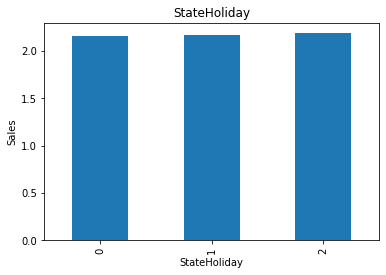

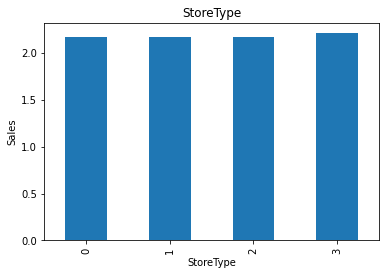

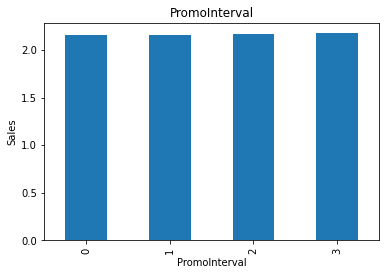

In [62]:
for var in cat_others:
    analyse_vars(X_train, y_train, var)

#### Feature scaling
For use in linear models, features need to be scaled. <br>
We will scale features to the minimum and maximum values

In [63]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [64]:
X_train.head()

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,CompetitionDistance_na,CompetitionOpenSinceMonth_na,CompetitionOpenSinceYear_na,Promo2SinceYear_na
0,0.833333,0.587547,0.0,0.0,0.5,0.0,0.333333,0.0,0.354962,0.727273,0.000000,1.0,0.333333,0.333333,0.0,1.0,1.0,0.0
1,0.500000,0.599320,0.0,0.0,0.5,0.0,0.333333,1.0,0.245362,0.727273,0.000000,1.0,0.333333,0.666667,0.0,1.0,1.0,0.0
2,0.500000,0.653409,0.0,1.0,0.5,0.0,0.333333,0.0,0.386900,0.363636,0.052174,1.0,0.000000,0.666667,0.0,0.0,0.0,0.0
3,0.000000,0.777498,0.0,1.0,0.5,0.0,0.000000,1.0,0.782834,0.727273,0.000000,1.0,0.666667,0.666667,0.0,1.0,1.0,0.0
4,0.833333,0.586215,0.0,0.0,0.5,0.0,0.333333,0.0,0.474427,0.727273,0.000000,0.0,0.333333,1.000000,0.0,1.0,1.0,1.0
